In [50]:
import pandas as pd
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [51]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
#olympics = pd.read_csv('/content/drive/MyDrive/athlete_events.csv',index_col='ID' ) index_col for select the index column
olympics = pd.read_csv('/content/drive/MyDrive/athlete_events.csv')
olympics.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [52]:
#Printing column wise missing values we get

print(olympics.isnull().sum())

ID             0
Name           0
Sex            0
Age         9474
Height     60171
Weight     62875
Team           0
NOC            0
Games          0
Year           0
Season         0
City           0
Sport          0
Event          0
Medal     231333
dtype: int64


In [53]:
# replace missing values in Medal by 'Did not win'
olympics['Medal'].fillna('DNW', inplace = True)

In [54]:
print(olympics.isnull().sum())

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64


In [55]:
#taking a unique subset of just the NOC and team columns and taking a value count
print(olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts().head())


NOC
FRA    160
USA     97
GBR     96
SWE     52
NOR     46
Name: count, dtype: int64


In [56]:
# Lets read in the noc_country mapping first
noc_country = pd.read_csv('/content/drive/MyDrive/noc_regions.csv')
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

noc_country.head()

,NOC,Country
0,AFG,Afghanistan
1,AHO,Curacao
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra


In [57]:
# We now need to merge the original dataset with the NOC master using the NOC code as the primary key. This has to be a left join since we want
# all participating countries to remain in the data even if their NOC-Country is not found in the master. We can easily correct those manually

olympics_merge = olympics.merge(noc_country,left_on = 'NOC',right_on = 'NOC',how = 'left')

In [58]:
# Do we have NOCs that didnt have a matching country in the master?
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()

,NOC,Team
578,SGP,Singapore
6267,ROT,Refugee Olympic Athletes
44376,SGP,June Climene
61080,UNK,Unknown
64674,TUV,Tuvalu
80986,SGP,Rika II
108582,SGP,Singapore-2
235895,SGP,Singapore-1


In [59]:
# Replace missing Teams by the values above.
#olympics_merge.loc[olympics_merge['Country'].isnull(), ['Country']] = olympics_merge['Team']

olympics_merge['Team'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Team'])
olympics_merge['Team'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Team'])
olympics_merge['Team'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Team'])
olympics_merge['Team'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Team'])


# Put these values from Country into Team
olympics_merge.drop('Team', axis = 1, inplace = True)
olympics_merge.rename(columns = {'Country': 'Team'}, inplace = True)

In [60]:
# Glance at the data.
w_gdp = pd.read_csv('/content/drive/MyDrive/world_gdp.csv', skiprows = 3)

# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp.head()

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN


In [61]:
#Before we actually merge, lets check if NOCs in the olympics data match with those in the Country Code.

len(list(set(olympics_merge['NOC'].unique()) - set(w_gdp['Country Code'].unique())))


108

In [62]:
#So, 108 NOCs in the olympics dataset dont have representation in the gdp data country codes. Is the name of the country a better way to merge?

len(list(set(olympics_merge['Team'].unique()) - set(w_gdp['Country Name'].unique())))


5

In [63]:
# Merge to get country code
olympics_merge_ccode = olympics_merge.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)

In [67]:
# Read in the population data
w_pop = pd.read_csv('/content/drive/MyDrive/world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type
w_pop['Year'] = pd.to_numeric(w_pop['Year'])

w_pop.head()

,Country,Country Code,Year,Population
0,Aruba,ABW,1960,54211.0
1,Afghanistan,AFG,1960,8996351.0
2,Angola,AGO,1960,5643182.0
3,Albania,ALB,1960,1608800.0
4,Andorra,AND,1960,13411.0


In [68]:
olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete.head()

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,DNW,China,CHN,4.269160e+11,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,DNW,China,CHN,8.560550e+12,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,DNW,Denmark,DNK,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,DNW,Netherlands,NLD,2.585680e+11,1.476009e+07


In [69]:
olympics_complete.isnull().sum()


,0
ID,0
Name,0
Sex,0
Age,9474
Height,60171
Weight,62875
NOC,0
Games,0
Year,0
Season,0


In [70]:
# Lets take data from 1961 onwards only and for summer olympics only
olympics_complete_subset = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

# Reset row indices
olympics_complete_subset = olympics_complete_subset.reset_index()

In [71]:
olympics_complete_subset.isnull().sum()

,0
index,0
ID,0
Name,0
Sex,0
Age,827
Height,7030
Weight,7294
NOC,0
Games,0
Year,0


In [72]:
# Let's create a column that captures whether or not a medal was won! It would be 1 if Medal column says Gold, Silver or Bronze and 0 otherwise.

olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'DNW', 0, 1)

In [73]:
# Check whether number of medals won in a year for an event by a team exceeds 1. This indicates a team event.
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]

team_sports = identify_team_events['Event'].unique()

In [74]:
#We need to remove these events from the list of team sports
remove_sports = ["Gymnastics Women's Balance Beam", "Gymnastics Men's Horizontal Bar",
                 "Swimming Women's 100 metres Freestyle", "Swimming Men's 50 metres Freestyle"]

team_sports = list(set(team_sports) - set(remove_sports))

In [75]:
# if an event name matches with one in team sports, then it is a team event. Others are singles events.
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

# rows where medal_won is 1
medal_mask = olympics_complete_subset['Medal_Won'] == 1

# Put 1 under team event if medal is won and event in team event list
olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)

# Put 1 under singles event if medal is won and event not in team event list
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)

# Add an identifier for team/single event
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + \
olympics_complete_subset['Team_Event']

<ipython-input-75-0aa0eaa86b68>:12: FutureWarning: Logical ops (and, or, xor) between Pandas objects and dtype-less sequences (e.g. list, tuple) are deprecated and will raise in a future version. Wrap the object in a Series, Index, or np.array before operating instead.
  olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)


In [76]:
medal_tally_agnostic = olympics_complete_subset.\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']

In [77]:
# Medal Tally.
medal_tally = medal_tally_agnostic.groupby(['Year','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Team',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:5]

# print total medals won in the given period
medal_tally_pivot.loc[:,'All']

,All
Team,
USA,1387.0
Russia,1298.0
Germany,1042.0
China,545.0


Text(0.5, 1.0, 'Olympic Performance Comparison')

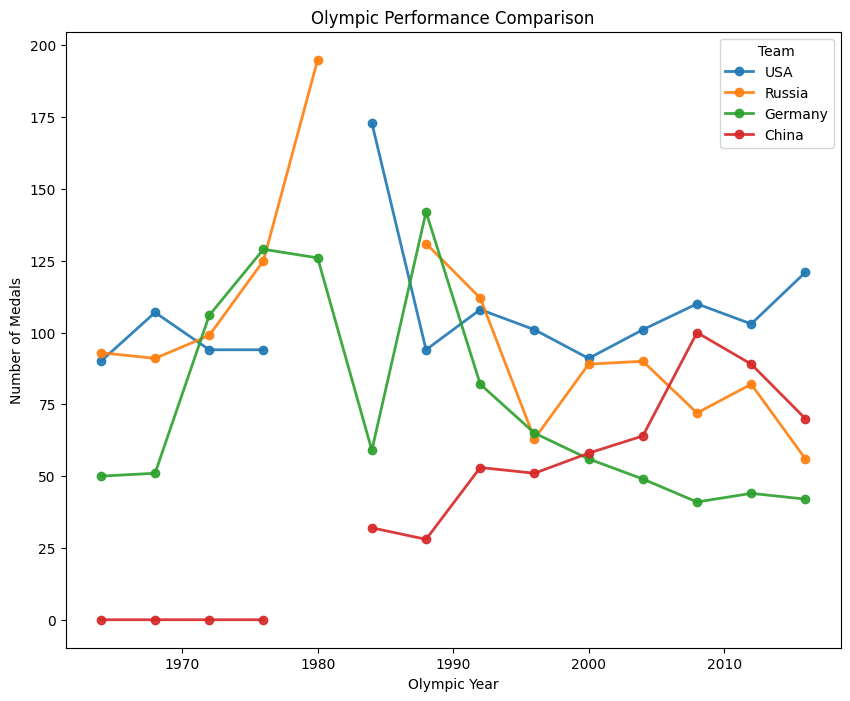

In [78]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

year_team_medals = pd.pivot_table(medal_tally,
                                  index = 'Year',
                                  columns = 'Team',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum')[top_countries]

# plotting the medal tallies
year_team_medals.plot(linestyle = '-', marker = 'o', alpha = 0.9, figsize = (10,8), linewidth = 2)
xlabel('Olympic Year')
ylabel('Number of Medals')
title('Olympic Performance Comparison')

Text(0, 0.5, 'Country')

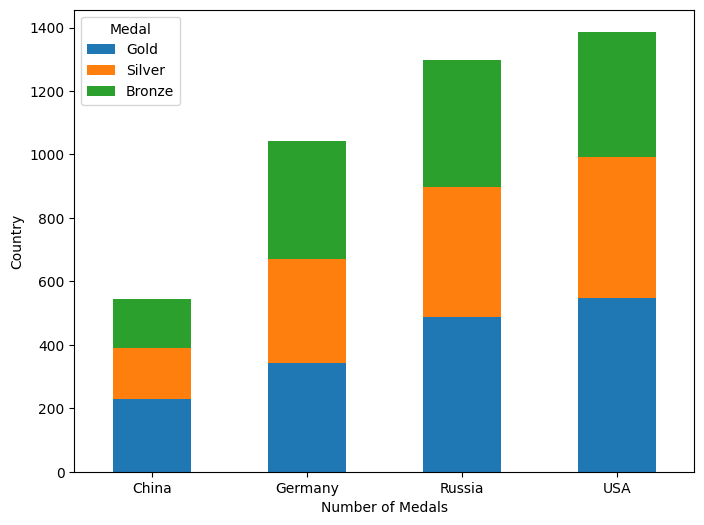

In [79]:
# List of top countries
top_countries = ['USA', 'Russia', 'Germany', 'China']

# row mask where countries match
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in top_countries)

# Pivot table to calculate sum of gold, silver and bronze medals for each country
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Team'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('DNW', axis = 1)

# Re-order the columns so that they appear in order on the chart.
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
xlabel('Number of Medals')
ylabel('Country')

In [80]:
# To get the sports, teams are best at, we now aggregate the medal_tally_agnostic dataframe as we did earlier.
best_team_sports = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum',
                                  fill_value = 0).sort_values(['Team', 'Gold'], ascending = [True, False]).reset_index()

best_team_sports.drop(['Bronze', 'Silver', 'DNW'], axis = 1, inplace = True)
best_team_sports.columns = ['Team', 'Event', 'Gold_Medal_Count']

best_team_sports.groupby('Team').head(5)

,Team,Event,Gold_Medal_Count
0,China,Diving Women's Springboard,8.0
1,China,Table Tennis Women's Singles,8.0
2,China,Diving Women's Platform,7.0
3,China,Weightlifting Men's Lightweight,6.0
4,China,Badminton Women's Doubles,5.0
343,Germany,"Equestrianism Mixed Dressage, Team",11.0
344,Germany,"Canoeing Women's Kayak Doubles, 500 metres",7.0
345,Germany,Rowing Men's Quadruple Sculls,7.0
346,Germany,Rowing Women's Quadruple Sculls,6.0
347,Germany,Athletics Men's Discus Throw,5.0


In [81]:
# take for each year, the team, name of the athlete and gender of the athlete and drop duplicates. These are values
# where the same athlete is taking part in more than one sport.

# get rows with top countries
row_mask_3 = olympics_complete_subset['Team'].map(lambda x: x in top_countries)

year_team_gender = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name', 'Sex']].drop_duplicates()

In [82]:
# Create a pivot table to count gender wise representation of each team in each year
year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

In [83]:
# Separate country wise data

chi_data = year_team_gender_count[year_team_gender_count['Team'] == "China"]
chi_data.fillna(0, inplace = True)
chi_data.set_index('Year', inplace = True)

ger_data = year_team_gender_count[year_team_gender_count['Team'] == "Germany"]
ger_data.set_index('Year', inplace = True)

rus_data = year_team_gender_count[year_team_gender_count['Team'] == "Russia"]
rus_data.set_index('Year', inplace = True)

usa_data = year_team_gender_count[year_team_gender_count['Team'] == "USA"]
usa_data.set_index('Year', inplace = True)

<ipython-input-83-c341fc2b705d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chi_data.fillna(0, inplace = True)


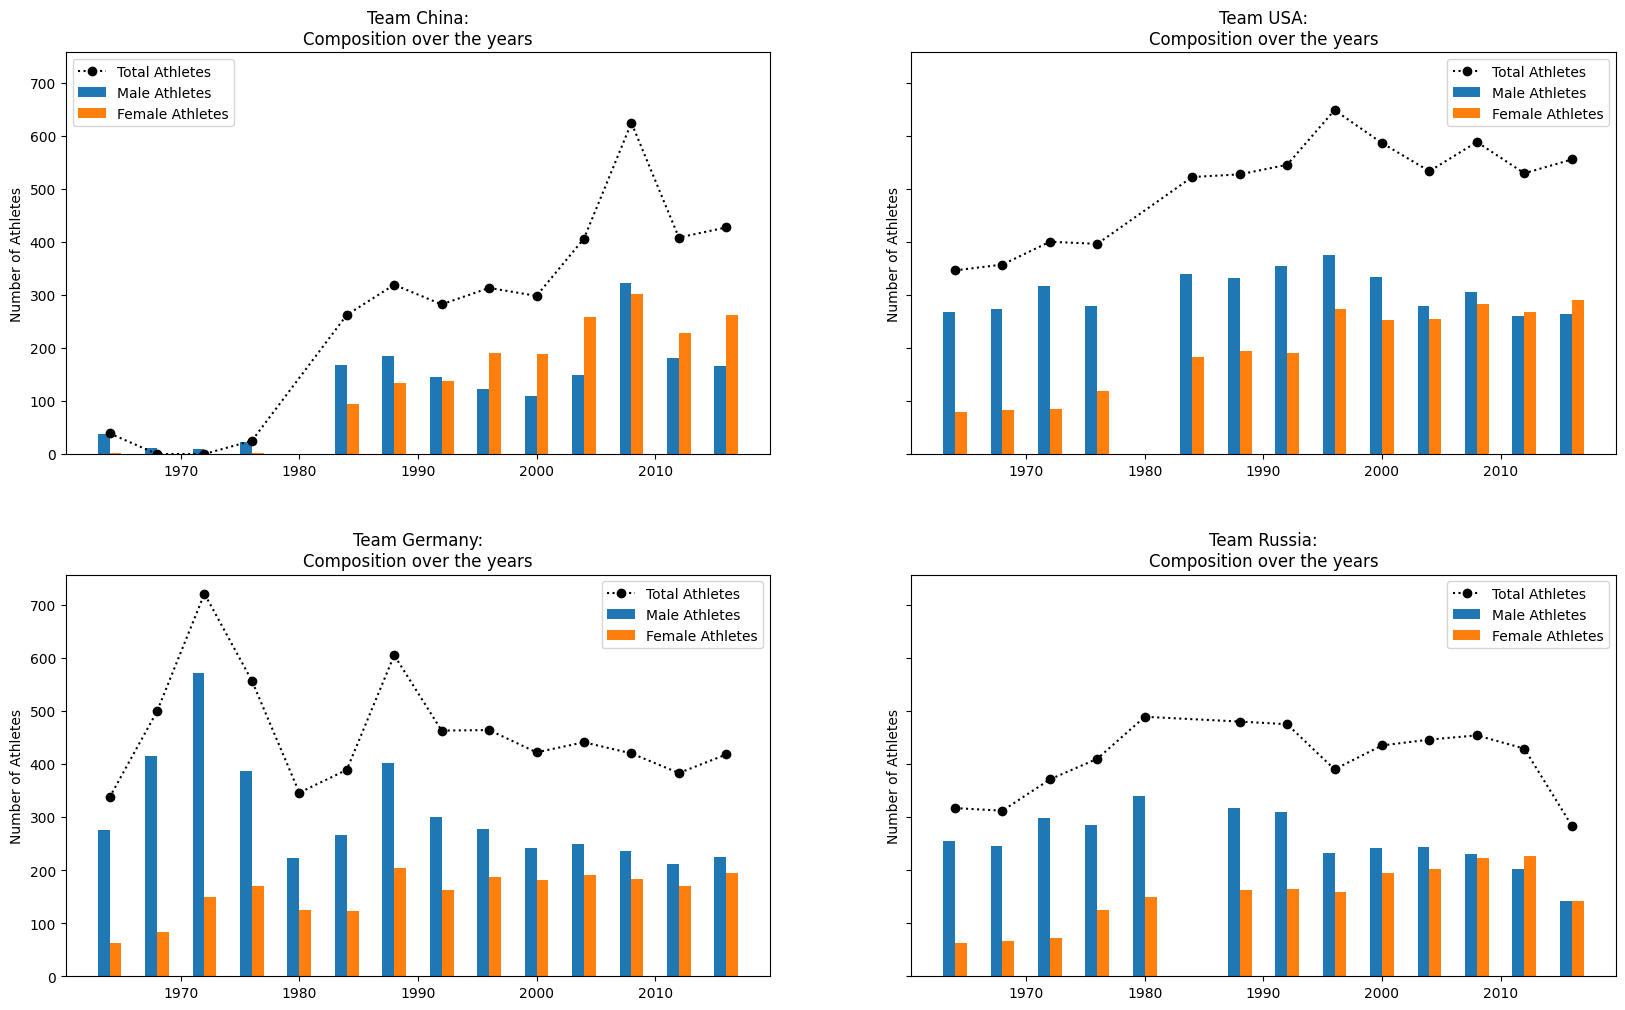

In [84]:

# Plot the values of male, female and total athletes using bar charts and the line charts.
fig, ((ax1, ax2), (ax3, ax4)) = subplots(nrows = 2, ncols = 2, figsize = (20, 12), sharey = True)
fig.subplots_adjust(hspace = 0.3)

# Plot team Australia's contingent size
ax1.bar(chi_data.index.values, chi_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax1.bar(chi_data.index.values, chi_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax1.plot(chi_data.index.values, chi_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax1.set_title('Team China:\nComposition over the years')
ax1.set_ylabel('Number of Athletes')
ax1.legend(loc = 'best')

# Plot team USA's contingent size
ax2.bar(usa_data.index.values, usa_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax2.bar(usa_data.index.values, usa_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax2.plot(usa_data.index.values, usa_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax2.set_title('Team USA:\nComposition over the years')
ax2.set_ylabel('Number of Athletes')
ax2.legend(loc = 'best')

# Plot team Germany's contingent size
ax3.bar(ger_data.index.values, ger_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax3.bar(ger_data.index.values, ger_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax3.plot(ger_data.index.values, ger_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
         marker = 'o')
ax3.set_title('Team Germany:\nComposition over the years')
ax3.set_ylabel('Number of Athletes')
ax3.legend(loc = 'best')

# Plot team Russia's contingent size
ax4.bar(rus_data.index.values, rus_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
ax4.bar(rus_data.index.values, rus_data['Female_Athletes'], width = 1, align = 'edge', label = 'Female Athletes')
ax4.plot(rus_data.index.values, rus_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
ax4.set_title('Team Russia:\nComposition over the years')
ax4.set_ylabel('Number of Athletes')
ax4.legend(loc = 'best')

show()

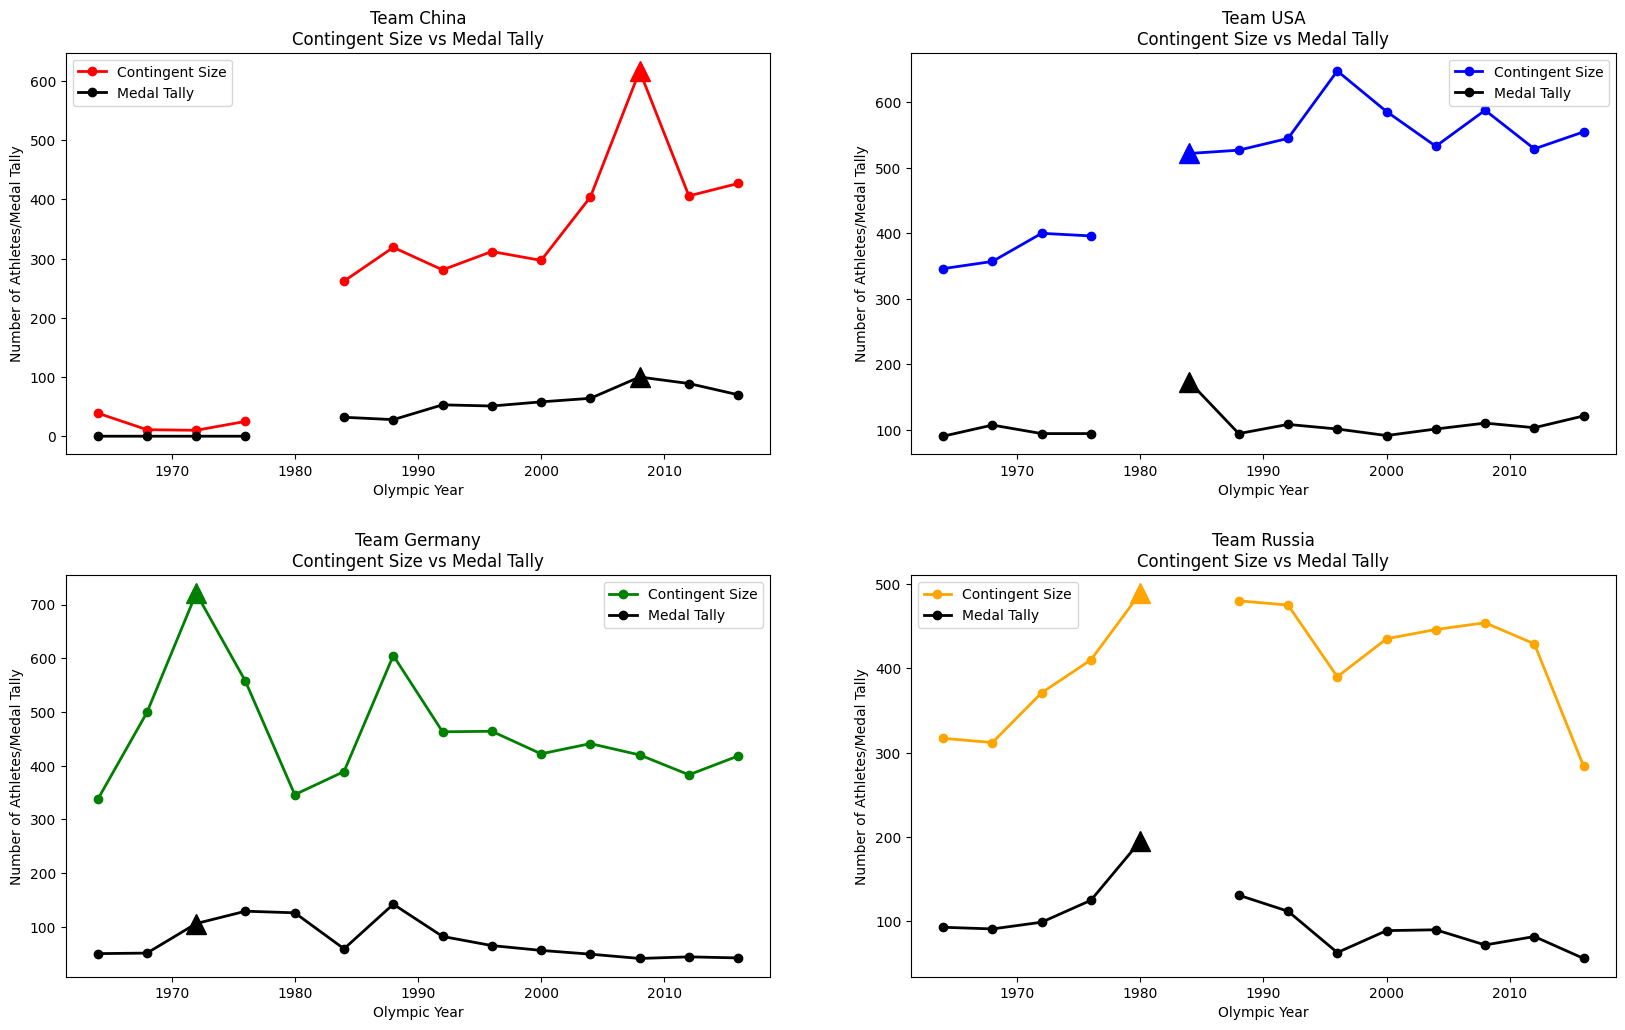

In [85]:
# Get year wise team wise athletes.
year_team_athelete = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name']].drop_duplicates()

# sum these up to get total contingent size.
contingent_size = pd.pivot_table(year_team_athelete,
                                 index = 'Year',
                                 columns = 'Team',
                                 values = 'Name',
                                 aggfunc = 'count')

fig, ((ax1, ax2), (ax3, ax4)) = subplots(nrows = 2,
                                         ncols = 2,
                                        figsize = (20,12))

fig.subplots_adjust(hspace = 0.3)

# Plot australia's medal tally and contingent size
contingent_size['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'red',
                                  label = 'Contingent Size')
year_team_medals['China'].plot(ax = ax1, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                  label = 'Medal Tally')
ax1.plot(2008, contingent_size.loc[2008, 'China'], marker = '^', color = 'red', ms = 14)
ax1.plot(2008, year_team_medals.loc[2008, 'China'], marker = '^', color = 'black', ms = 14)
ax1.set_xlabel('Olympic Year')
ax1.set_ylabel('Number of Athletes/Medal Tally')
ax1.set_title('Team China\nContingent Size vs Medal Tally')
ax1.legend(loc = 'best')

# Plot USA's medal tally and contingent size
contingent_size['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'blue',
                           label = 'Contingent Size')
year_team_medals['USA'].plot(ax = ax2, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                            label = 'Medal Tally')
ax2.plot(1984, contingent_size.loc[1984, 'USA'], marker = '^', color = 'blue', ms = 14)
ax2.plot(1984, year_team_medals.loc[1984, 'USA'], marker = '^', color = 'black', ms = 14)
ax2.set_xlabel('Olympic Year')
ax2.set_ylabel('Number of Athletes/Medal Tally')
ax2.set_title('Team USA\nContingent Size vs Medal Tally')
ax2.legend(loc = 'best')

# Plot Germany's medal tally and contingent size
contingent_size['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'green',
                               label = 'Contingent Size')
year_team_medals['Germany'].plot(ax = ax3, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                                label = 'Medal Tally')
ax3.plot(1972, year_team_medals.loc[1972, 'Germany'], marker = '^', color = 'black', ms = 14)
ax3.plot(1972, contingent_size.loc[1972, 'Germany'], marker = '^', color = 'green', ms = 14)
ax3.set_xlabel('Olympic Year')
ax3.set_ylabel('Number of Athletes/Medal Tally')
ax3.set_title('Team Germany\nContingent Size vs Medal Tally')
ax3.legend(loc = 'best')

# Plot Russia's medal tally and contingent size
contingent_size['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'orange',
                              label = 'Contingent Size')
year_team_medals['Russia'].plot(ax = ax4, linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                               label = 'Medal Tally')
ax4.plot(1980, contingent_size.loc[1980, 'Russia'], marker = '^', color = 'orange', ms = 14)
ax4.plot(1980, year_team_medals.loc[1980, 'Russia'], marker = '^', color = 'black', ms = 14)
ax4.set_xlabel('Olympic Year')
ax4.set_ylabel('Number of Athletes/Medal Tally')
ax4.set_title('Team Russia\nContingent Size vs Medal Tally')
ax4.legend(loc = 'best')

show()

In [87]:
# Lets merge contingent size and medals won!
year_team_medals_unstack = year_team_medals.unstack().reset_index()
year_team_medals_unstack.columns = ['Team','Year', 'Medal_Count']

contingent_size_unstack = contingent_size.unstack().reset_index()

contingent_size_unstack.columns = ['Team','Year', 'Contingent']

contingent_medals = contingent_size_unstack.merge(year_team_medals_unstack,
                                                 left_on = ['Team', 'Year'],
                                                 right_on = ['Team', 'Year'])

contingent_medals[['Contingent', 'Medal_Count']].corr()


,Contingent,Medal_Count
Contingent,1.000000,0.703625
Medal_Count,0.703625,1.000000


In [88]:
# merge best team sports with olympics data to get sport for each event.
team_commonalities = best_team_sports.merge(olympics_complete_subset.loc[:,['Sport', 'Event']].drop_duplicates(),
                                           left_on = 'Event',
                                           right_on = 'Event')

team_commonalities = team_commonalities.sort_values(['Team', 'Gold_Medal_Count'], ascending = [True, False])
team_commonalities = team_commonalities.groupby('Team').head(5).reset_index()

# make a pivot table of the commonalities.
pd.pivot_table(team_commonalities,
              index = 'Sport',
              columns = 'Team',
              values = 'Event',
              aggfunc = 'count',
              fill_value = 0,
              margins = True).sort_values('All', ascending = False)[1:]

Team,China,Germany,Russia,USA,All
Sport,,,,,
Athletics,0,1,0,2,3
Diving,2,0,0,0,2
Rowing,0,2,0,0,2
Swimming,0,0,0,2,2
Wrestling,0,0,2,0,2
Badminton,1,0,0,0,1
Basketball,0,0,0,1,1
Canoeing,0,1,0,0,1
Equestrianism,0,1,0,0,1


In [89]:
#Where was the olympics held in each of the years under consideration
olympics_complete_subset[['Year', 'City']].drop_duplicates().sort_values('Year')


,Year,City
74,1964,Tokyo
11,1968,Mexico City
12,1972,Munich
37,1976,Montreal
70,1980,Moskva
10,1984,Los Angeles
13,1988,Seoul
0,1992,Barcelona
3,1996,Atlanta
2,2000,Sydney


In [90]:
# Correct city names in the dataset
olympics_complete_subset['City'].replace(['Athina', 'Moskva'], ['Athens', 'Moscow'], inplace = True)

In [91]:
# city to country mapping dictionary
city_to_country = {'Tokyo': 'Japan',
                  'Mexico City': 'Mexico',
                  'Munich': 'Germany',
                  'Montreal': 'Canada',
                  'Moscow': 'Russia',
                  'Los Angeles': 'USA',
                  'Seoul': 'South Korea',
                  'Barcelona': 'Spain',
                  'Atlanta': 'USA',
                  'Sydney': 'Australia',
                  'Athens': 'Greece',
                  'Beijing': 'China',
                  'London': 'UK',
                  'Rio de Janeiro': 'Brazil'}

# Map cities to countries
olympics_complete_subset['Country_Host'] = olympics_complete_subset['City'].map(city_to_country)

#print the
olympics_complete_subset.loc[:, ['Year', 'Country_Host']].drop_duplicates().sort_values('Year')

,Year,Country_Host
74,1964,Japan
11,1968,Mexico
12,1972,Germany
37,1976,Canada
70,1980,Russia
10,1984,USA
13,1988,South Korea
0,1992,Spain
3,1996,USA
2,2000,Australia


In [92]:
# Extract year, host nation and team name from the data
year_host_team = olympics_complete_subset[['Year', 'Country_Host', 'Team']].drop_duplicates()

# check rows where host country is the same as team
row_mask_4 = (year_host_team['Country_Host'] == year_host_team['Team'])

# add years in the year_host_team to capture one previous and one later year
year_host_team['Prev_Year'] = year_host_team['Year'] - 4
year_host_team['Next_Year'] = year_host_team['Year'] + 4

# Subset only where host nation and team were the same
year_host_team = year_host_team[row_mask_4]

# Calculate the medals won in each year where a team played at home. merge year_host_team with medal_tally on year and team
year_host_team_medal = year_host_team.merge(medal_tally,
                                           left_on = ['Year', 'Team'],
                                           right_on = ['Year', 'Team'],
                                           how = 'left')

year_host_team_medal.rename(columns = {'Medal_Won_Corrected' : 'Medal_Won_Host_Year'}, inplace = True)

# Calculate medals won by team in previous year
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Prev_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Medal_Won_Corrected': 'Medal_Won_Prev_Year',
                                      'Year_x':'Year'}, inplace = True)

# Calculate the medals won by the team the year after they hosted.
year_host_team_medal = year_host_team_medal.merge(medal_tally,
                                                 left_on = ['Next_Year', 'Team'],
                                                 right_on = ['Year', 'Team'],
                                                 how = 'left')

year_host_team_medal.drop('Year_y', axis = 1, inplace = True)
year_host_team_medal.rename(columns = {'Year_x': 'Year',
                                      'Medal_Won_Corrected' : 'Medal_Won_Next_Year'}, inplace = True)

# General formatting changes
year_host_team_medal.drop(['Prev_Year', 'Next_Year'], axis = 1, inplace = True)
year_host_team_medal.sort_values('Year', ascending = True, inplace = True)
year_host_team_medal.reset_index(inplace = True, drop = True)

# column re-ordering
year_host_team_medal = year_host_team_medal.loc[:, ['Year', 'Country_Host', 'Team', 'Medal_Won_Prev_Year', 'Medal_Won_Host_Year', 'Medal_Won_Next_Year']]

year_host_team_medal

,Year,Country_Host,Team,Medal_Won_Prev_Year,Medal_Won_Host_Year,Medal_Won_Next_Year
0,1964,Japan,Japan,NaN,29.0,25.0
1,1968,Mexico,Mexico,1.0,9.0,1.0
2,1972,Germany,Germany,51.0,106.0,129.0
3,1976,Canada,Canada,5.0,11.0,NaN
4,1980,Russia,Russia,125.0,195.0,NaN
5,1984,USA,USA,NaN,173.0,94.0
6,1988,South Korea,South Korea,19.0,33.0,28.0
7,1992,Spain,Spain,4.0,22.0,17.0
8,1996,USA,USA,108.0,101.0,91.0
9,2000,Australia,Australia,41.0,58.0,50.0


<ipython-input-93-7daf14985fe1>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  correlation = medal_tally_gdp.loc[row_mask_5, ['GDP', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]


Text(7194878000000.113, 145.0, 'Correlation = 0.6229490657900137')

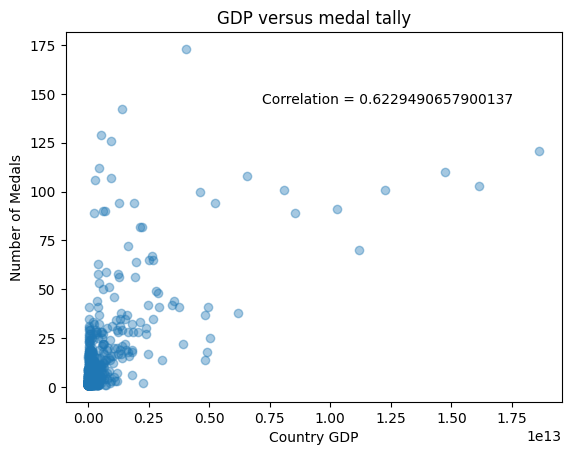

In [93]:
year_team_gdp = olympics_complete_subset.loc[:, ['Year', 'Team', 'GDP']].drop_duplicates()

medal_tally_gdp = medal_tally.merge(year_team_gdp,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   how = 'left')

row_mask_5 = medal_tally_gdp['Medal_Won_Corrected'] > 0
row_mask_6 = medal_tally_gdp['Team'].map(lambda x: x in top_countries)

correlation = medal_tally_gdp.loc[row_mask_5, ['GDP', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]

plot(medal_tally_gdp.loc[row_mask_5, 'GDP'],
     medal_tally_gdp.loc[row_mask_5, 'Medal_Won_Corrected'] ,
     linestyle = 'none',
     marker = 'o',
    alpha = 0.4)
xlabel('Country GDP')

ylabel('Number of Medals')
title('GDP versus medal tally')
text(np.nanpercentile(medal_tally_gdp['GDP'], 99.6),
     max(medal_tally_gdp['Medal_Won_Corrected']) - 50,
     "Correlation = " + str(correlation))


In [94]:
# lets create a data frame of athletes with the sport they participated in and the number of medals won.
ath_sport_medal = olympics_complete_subset.groupby(['Team','Name', 'Sport'])['Medal_Won'].agg('sum').reset_index()
ath_sport_medal.sort_values(['Sport', 'Medal_Won'], ascending = [True, False], inplace = True)

# keep only athletes who won medals
medal_mask = ath_sport_medal['Medal_Won'] > 0
ath_sport_medal = ath_sport_medal[medal_mask]

ath_sport_medal.head()

,Team,Name,Sport,Medal_Won
65986,South Korea,Kim Su-Nyeong,Archery,6
65643,South Korea,Ki Bo-Bae,Archery,4
66594,South Korea,Park Seong-Hyeon,Archery,4
16642,China,Zhang Juanjuan,Archery,3
39055,Italy,Marco Galiazzo,Archery,3


In [95]:
# Now lets calculate the number of participations of each athlete. This will be sport wise.
ath_sport_appearance = olympics_complete_subset.groupby(['Team', 'Name', 'Sport'])['NOC'].agg('count').reset_index()

ath_sport_appearance.rename(columns = {'NOC': 'Event_Count'}, inplace = True)

ath_sport_appearance.head()

# lets merge these two.
ath_medal_appearance = ath_sport_medal.merge(ath_sport_appearance,
                                            left_on = ["Team", "Name", "Sport"],
                                            right_on = ['Team', 'Name', 'Sport'],
                                            how = "left")

# Calculate the medal per participation
ath_medal_appearance['Medal_Per_Participation'] = ath_medal_appearance['Medal_Won']/ath_medal_appearance['Event_Count']

ath_medal_appearance.sort_values(['Medal_Per_Participation', 'Medal_Won'], ascending = [False, False], inplace = True)

ath_medal_appearance.head(10)


,Team,Name,Sport,Medal_Won,Event_Count,Medal_Per_Participation
12179,USA,Natalie Anne Coughlin (-Hall),Swimming,12,12,1.0
150,USA,"Frederick Carlton ""Carl"" Lewis",Athletics,10,10,1.0
4925,Germany,Isabelle Regina Werth,Equestrianism,10,10,1.0
12184,USA,"Gary Wayne Hall, Jr.",Swimming,10,10,1.0
5296,Italy,Maria Valentina Vezzali,Fencing,9,9,1.0
12191,Germany,"Kornelia Ender (-Matthes, -Grummt)",Swimming,8,8,1.0
12195,USA,"Donald Arthur ""Don"" Schollander",Swimming,8,8,1.0
12197,USA,Nathan Ghar-Jun Adrian,Swimming,8,8,1.0
4191,UK,Jason Francis Kenny,Cycling,7,7,1.0
4745,China,Wu Minxia,Diving,7,7,1.0


In [96]:
# filter out athletes with less than 10 total medals.
ath_medal_appearance = ath_medal_appearance[ath_medal_appearance['Medal_Won'] >= 10]

ath_medal_appearance

,Team,Name,Sport,Medal_Won,Event_Count,Medal_Per_Participation
12179,USA,Natalie Anne Coughlin (-Hall),Swimming,12,12,1.000000
150,USA,"Frederick Carlton ""Carl"" Lewis",Athletics,10,10,1.000000
4925,Germany,Isabelle Regina Werth,Equestrianism,10,10,1.000000
12184,USA,"Gary Wayne Hall, Jr.",Swimming,10,10,1.000000
12176,USA,"Michael Fred Phelps, II",Swimming,28,30,0.933333
3614,Germany,Birgit Fischer-Schmidt,Canoeing,12,13,0.923077
12177,USA,"Dara Grace Torres (-Hoffman, -Minas)",Swimming,12,13,0.923077
12181,USA,Mark Andrew Spitz,Swimming,11,12,0.916667
12182,USA,"Matthew Nicholas ""Matt"" Biondi",Swimming,11,12,0.916667
12180,USA,Ryan Steven Lochte,Swimming,12,14,0.857143


In [97]:
# create the year, team contingent size
year_team_gender = olympics_complete_subset.loc[:,['Year','Team', 'Name', 'Sex']].drop_duplicates()

year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']
year_team_gender_count = year_team_gender_count.fillna(0)

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

year_team_contingent = year_team_gender_count.loc[:, ['Year', 'Team','Total_Athletes']]
year_team_contingent.head()


,Year,Team,Total_Athletes
0,1964,Afghanistan,8.0
1,1964,Algeria,1.0
2,1964,Argentina,102.0
3,1964,Australia,243.0
4,1964,Austria,56.0


In [98]:
# get year, team and GDP - medal_tally_gdp has it
medal_tally_gdp.head()

,Year,Team,Medal_Won_Corrected,GDP
0,1964,Afghanistan,0.0,8.000000e+08
1,1964,Algeria,0.0,2.909352e+09
2,1964,Argentina,1.0,2.560525e+10
3,1964,Australia,18.0,2.378766e+10
4,1964,Austria,0.0,9.169984e+09


In [99]:
# Get year team population
year_team_pop = olympics_complete_subset.loc[:, ['Year', 'Team', 'Population']].drop_duplicates()
year_team_pop.head()

,Year,Team,Population
0,1992,China,1.164970e+09
1,2012,China,1.350695e+09
2,2000,Finland,5.176209e+06
3,1996,Finland,5.124573e+06
6,2008,Norway,4.768212e+06


In [100]:
# merge all these datasets together
medal_gdp_population = medal_tally_gdp.merge(year_team_pop,
                                            left_on = ['Year', 'Team'],
                                            right_on = ['Year', 'Team'],
                                            how = 'left')

medal_gdp_pop_contingent = medal_gdp_population.merge(year_team_contingent,
                                                     left_on = ['Year', 'Team'],
                                                     right_on = ['Year', 'Team'],
                                                     how = 'left')
medal_gdp_pop_contingent.head()

,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes
0,1964,Afghanistan,0.0,8.000000e+08,9731361.0,8.0
1,1964,Algeria,0.0,2.909352e+09,12295970.0,1.0
2,1964,Argentina,1.0,2.560525e+10,21953929.0,102.0
3,1964,Australia,18.0,2.378766e+10,11167000.0,243.0
4,1964,Austria,0.0,9.169984e+09,7223801.0,56.0


In [101]:
# get host nation from the data
year_host = olympics_complete_subset.loc[:, ['Year', 'Country_Host']].drop_duplicates()

# merge this with the larger dataset
lin_model_data = medal_gdp_pop_contingent.merge(year_host,
                              left_on = 'Year',
                              right_on = 'Year',
                              how = 'left')

lin_model_data.head()

,Year,Team,Medal_Won_Corrected,GDP,Population,Total_Athletes,Country_Host
0,1964,Afghanistan,0.0,8.000000e+08,9731361.0,8.0,Japan
1,1964,Algeria,0.0,2.909352e+09,12295970.0,1.0,Japan
2,1964,Argentina,1.0,2.560525e+10,21953929.0,102.0,Japan
3,1964,Australia,18.0,2.378766e+10,11167000.0,243.0,Japan
4,1964,Austria,0.0,9.169984e+09,7223801.0,56.0,Japan


Text(0.5, 1.0, 'Population Distribution')

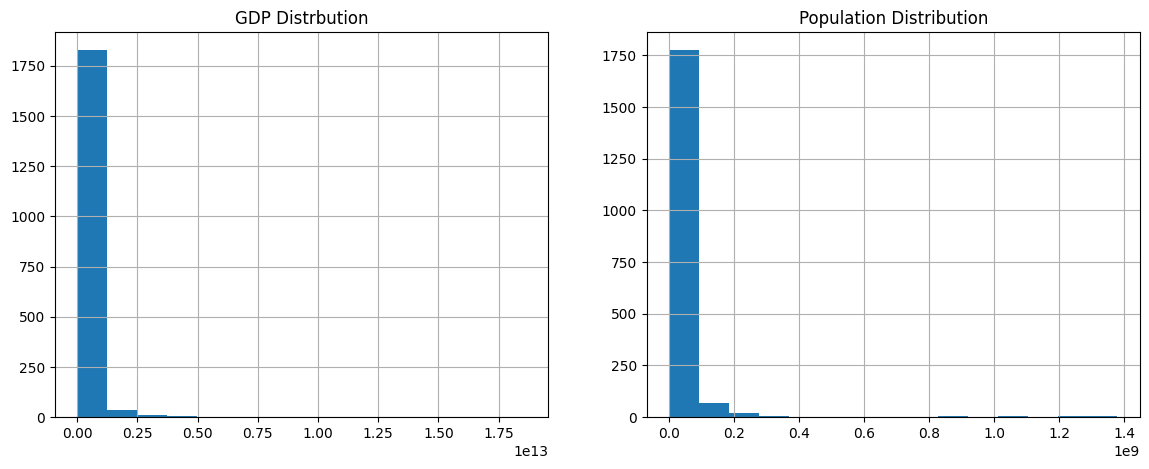

In [102]:
# Regression model
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics

# add indicator to see whether home advantage
lin_model_data['Home_adv'] = np.where(lin_model_data['Country_Host'] == lin_model_data['Team'], 1, 0)

# Add per capita GDP
lin_model_data['GDP_per_capita'] = lin_model_data['GDP']/lin_model_data['Population']

# remove NAs
lin_model_data.dropna(how = 'any', inplace = True)


# Lets see the distrbution of population and GDP in a histogram

fig, (ax1, ax2) = subplots(nrows = 1,
                          ncols = 2,
                          figsize = (14,5))

lin_model_data['GDP'].hist(bins = 15, ax = ax1)
ax1.set_title('GDP Distrbution')

lin_model_data['Population'].hist(bins = 15, ax = ax2)
ax2.set_title('Population Distribution')


In [103]:
import math

# take the log transforms for the variables
lin_model_data['Log_Population'] = np.log(lin_model_data['Population'])
lin_model_data['Log_GDP'] = np.log(lin_model_data['GDP'])

In [104]:
# regression model
y, X = dmatrices('Medal_Won_Corrected ~ Log_GDP + Log_Population + Total_Athletes + Home_adv + GDP_per_capita',
                data = lin_model_data,
                return_type = 'dataframe')

model = sm.OLS(y, X)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Medal_Won_Corrected   R-squared:                       0.755
Model:                             OLS   Adj. R-squared:                  0.754
Method:                  Least Squares   F-statistic:                     1161.
Date:                 Tue, 20 Aug 2024   Prob (F-statistic):               0.00
Time:                         13:31:47   Log-Likelihood:                -6410.7
No. Observations:                 1892   AIC:                         1.283e+04
Df Residuals:                     1886   BIC:                         1.287e+04
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         17.0064      2.242      7.585      0.000      12.609      21.404
Log_GDP           -1.1460      0.162     -7.083      0.000      -1.463      -0.829
Log_Population     0.4034      0.156      2.584      0.010       0.097       0.710
Total_Athletes     0.1467      0.003     58.139      0.000       0.142       0.152
Home_adv          -8.0876      2.189     -3.695      0.000     -12.380      -3.795
GDP_per_capita  1.268e-05   1.49e-05      0.850      0.396   -1.66e-05    4.19e-05
==============================================================================
Omnibus:                     1839.710   Durbin-Watson:                   2.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           248031.734
Skew:                           4.212   Prob(JB):                         0.00
Kurtosis:                      58.456   Cond. No.                     2.63e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.63e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [105]:
# what is the error associated with this prediction?
y_predicted = result.predict(X)
np.sqrt(metrics.mean_squared_error(y, y_predicted))

7.1664213376282495

In [106]:
# How many unique sports are there?
olympics_complete_subset['Sport'].unique()

array(['Basketball', 'Judo', 'Badminton', 'Sailing', 'Athletics',
       'Handball', 'Weightlifting', 'Wrestling', 'Water Polo', 'Hockey',
       'Rowing', 'Swimming', 'Football', 'Equestrianism', 'Boxing',
       'Gymnastics', 'Taekwondo', 'Fencing', 'Diving', 'Canoeing',
       'Tennis', 'Shooting', 'Cycling', 'Softball', 'Archery',
       'Volleyball', 'Synchronized Swimming', 'Modern Pentathlon',
       'Table Tennis', 'Baseball', 'Rhythmic Gymnastics', 'Rugby Sevens',
       'Trampolining', 'Beach Volleyball', 'Triathlon', 'Golf'],
      dtype=object)

In [107]:
# extract sports data for males and height, weight statistics
base_data_male = olympics_complete_subset.loc[olympics_complete_subset['Sex'] == "M",
                                              ['Sport', 'Age','Weight', 'Height']].drop_duplicates()

In [108]:
# Need to create y, X for the K nearest neighbors problem
Y, X = dmatrices('Sport ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

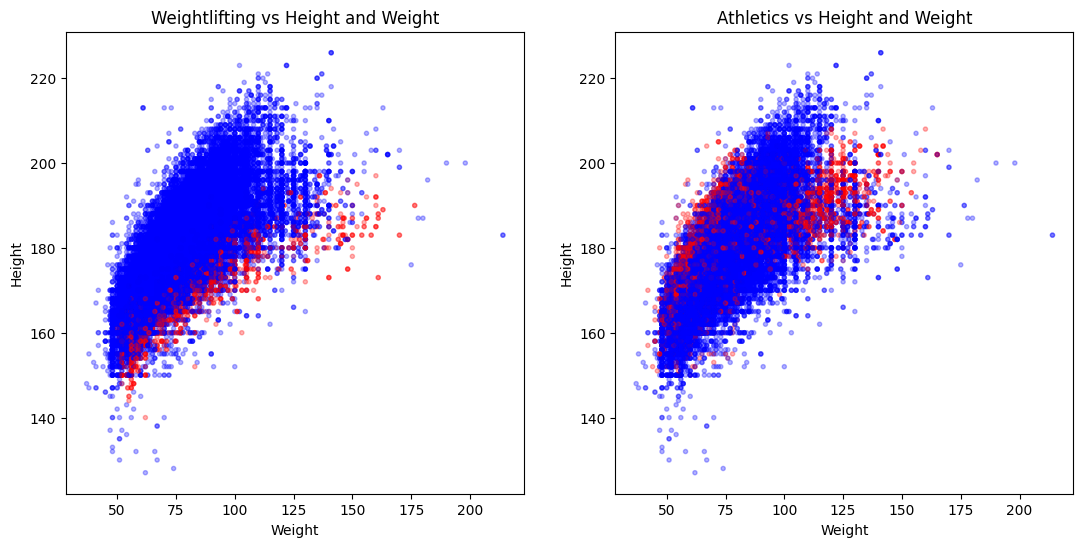

In [109]:
fig, (ax1, ax2) = subplots(nrows = 1, ncols = 2, figsize = (13,6))

ax1.scatter(X['Weight'], X['Height'], c = Y['Sport[Weightlifting]'], cmap = 'bwr', marker = '.', alpha = 0.3)
ax1.set_title('Weightlifting vs Height and Weight')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Height')

ax2.scatter(X['Weight'], X['Height'], c = Y['Sport[Athletics]'], cmap = 'bwr', marker = '.', alpha = 0.3)
ax2.set_title('Athletics vs Height and Weight')
ax2.set_xlabel('Weight')
ax2.set_ylabel('Height')

show()

In [110]:
base_data_male['target'] = np.where(base_data_male['Sport'] == 'Weightlifting', 1, 0)


In [111]:
# create the y and X matrices
from sklearn import model_selection
from sklearn import metrics
from sklearn import neighbors

Y, X = dmatrices('target ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

y = Y['target'].values

accuracies = []

kfold = model_selection.StratifiedKFold(n_splits = 5, shuffle = True).split(X, y)

model = neighbors.KNeighborsClassifier(n_neighbors = 20,
                                      p = 2,
                                      weights = 'uniform')

for train, holdout in kfold:
    model.fit(X.iloc[train], y[train])
    prediction_on_test = model.predict(X.iloc[holdout])
    accuracies.append(metrics.accuracy_score(y[holdout], prediction_on_test))

np.mean(accuracies)


0.9692244132807067

In [112]:
# Predicting Athletics from height and weight
base_data_male['target'] = np.where(base_data_male['Sport'] == 'Athletics', 1, 0)

# create the y and X matrices
from sklearn import model_selection
from sklearn import metrics
from sklearn import neighbors

Y, X = dmatrices('target ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

y = Y['target'].values

accuracies = []

kfold = model_selection.StratifiedKFold(n_splits = 5, shuffle = True).split(X, y)

model = neighbors.KNeighborsClassifier(n_neighbors = 20,
                                      p = 2,
                                      weights = 'uniform')

for train, holdout in kfold:
    model.fit(X.iloc[train], y[train])
    prediction_on_test = model.predict(X.iloc[holdout])
    accuracies.append(metrics.accuracy_score(y[holdout], prediction_on_test))

np.mean(accuracies)

0.85673661367212